# Distracted Driver Classification

### Satchel Grant

The goal of this notebook is to classify the distraction type of the driver of a car. For my personal purposes, I wanted to try implementing an inception net for image classification.

## Initial Imports

In [16]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.utils import shuffle
import pickle

%matplotlib inline

def show_img(img):
    plt.imshow(img)
    plt.show()

## Read in Data

In [2]:
external_drive_path = '/Volumes/WhiteElephant/'
home_path = os.getcwd()
os.chdir(external_drive_path)

In [3]:
path = './statefarm_drivers/imgs/train'

label_types = []
img_files = dict()
for dir_name, subdir_list, file_list in os.walk(path):
    if len(subdir_list) > 0:
        label_types = subdir_list
        for subdir in subdir_list:
            img_files[subdir] = []
    for img_file in file_list:
        if '.jpg' in img_file.lower():
            img_files[dir_name[-2:]].append(os.path.join(dir_name,img_file))



(480, 640, 3)


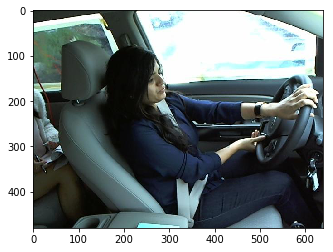

In [5]:
images = []
labels = []
counter = 0
for i,label in enumerate(label_types):
    files = img_files[label]
    for file in files:
        images.append(mpimg.imread(file))
        labels.append(i)
        if counter == i:
            counter+=1
            print("Classification: " + labels[-1])
            show_img(images[-1])

In [38]:
img_shape = images[0].shape
print("Total Image Count: " + str(len(images)))
print("Image Shape: " + str('x'.join([str(s) for s in img_shape])))

Total Image Count: 7400
Image Shape: 480x640x3


### Split into Training and Validation Sets

In [11]:
## Split Into Training and Validation

images, labels = shuffle(images, labels)

split_index = int(len(images)*.67)

train_images = images[:split_index]
train_labels = labels[:split_index]
valid_images = images[split_index:]
valid_labels = labels[split_index:]

del images
del labels

In [17]:
bitsPerGb = 8*10**9
image_cells = img_shape[0]*img_shape[1]*img_shape[2]
bitsPerCell = 32
gbSize = 1.2
pickle_size = int(gbSize*bitsPerGb/(image_cells*bitsPerCell))

path = './statefarm_drivers/imgs/pickles/'

for name, images, labels in zip(['train','valid'], [train_images, valid_images], [train_labels, valid_labels]):
    for batch in range(1,len(images)//pickle_size+1):
        pickle_d = dict()
        if batch == len(images)//pickle_size:
            pickle_d['features'] = np.array(images[pickle_size*(batch-1):], dtype=np.float32)
            pickle_d['labels'] = np.array(labels[pickle_size*(batch-1):], dtype=np.float32)
        else:
            pickle_d['features'] = np.array(images[pickle_size*(batch-1):pickle_size*batch], dtype=np.float32)
            pickle_d['labels'] = np.array(labels[pickle_size*(batch-1):pickle_size*batch], dtype=np.float32)
            
        with open(path+name+str(batch)+'.p', 'wb') as f:
            pickle.dump(pickle_d, f)
del pickle_d

In [18]:
del pickle_d

### Understanding the Data


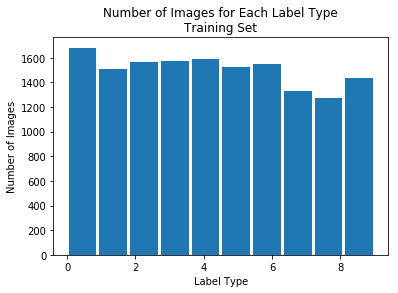

In [31]:
## Label Distributions

plt.hist(train_labels, 10, rwidth=.9)
plt.ylabel("Number of Images")
plt.xlabel("Label Type")
plt.title("Number of Images for Each Label Type\nTraining Set")
plt.show()

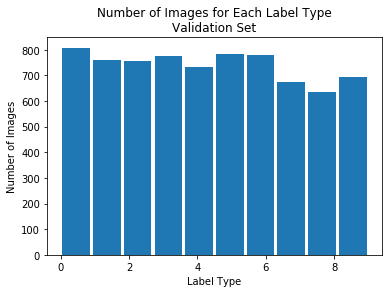

In [32]:
plt.hist(valid_labels, 10, rwidth=.9)
plt.ylabel("Number of Images")
plt.xlabel("Label Type")
plt.title("Number of Images for Each Label Type\nValidation Set")
plt.show()

## Preprocessing

In [ ]:
PROCESS_MEAN = np.mean(train_images)
PROCESS_DEV = np.std(train_images)

def gray(images):
    return np.mean(images,-1) ## Not standard gray format, but should work fine for preprocessing purposes

def centernorm(images):
    return (images-PROCESS_MEAN)/PROCESS_DEV

def one_hot_encode(labels, n_labels):
    encoded_labels = np.zeros((labels.shape[0], n_labels), dtype=np.float32)
    for i,label in enumerate(labels):
        encoded_labels[i,int(label)] = 1
    return encoded_labels

def preprocess(images, labels, n_labels, make_gray=False):
    if make_gray:
        images = gray(images)
    images = centernorm(images)
    labels = one_hot_encode(labels, n_labels)
    return images, labels

In [ ]:
train_images, train_labels = preprocess(train_images, train_labels, n_labels)
valid_images, valid_labels = preprocess(valid_images, valid_labels, n_labels)

## Define Neural Net Architecture
The inception net is a way to use multiple types of convolution structures together. The idea is to run each a 1x1, 3x3, and 5x5 convolution kernel in addition to a max-pool operation at each layer in the net.

## Run Session